#### Introduction

In this notebook, we will classify images the Cifar-10 images. 

Covered in this notebook will be:
* Image Data Augmentation
* Validation Data
* Model Architecture
    * Convolutional Neural Networks
    * Batch Normalization
    * Max Pooling
    * Regularization (Dropout)
* Transfer Learning
* Training Example with Tensorflow/Keras
* Interpreting Validation Data
* Interpreting Results (using multiple metrics) and Model Selection (and how to include Stakeholders)

In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# We will be using a pre-trained ResNet18 model to discuss transfer learning. The ResNet18 model was converted from the
# pre-trained ResNet18 available by default with pytorch using this repo: https://github.com/dmolony3/Torch_to_TF
RESNET_MODEL = "./model/resnet18.h5"

# Define the save directories
CP_DIR = "./results/CIFAR10/checkpoints" # checkpoint directory
SAVE_VIS = True # Do you want to save visualizations of model architecture and results?

# Make the checkpoint directory if it doesn't exist
os.makedirs(CP_DIR, exist_ok=True)

# Make the save dir if it does not exist
if SAVE_VIS:
    VIS_DIR = "./results/CIFAR10/visualizations"
    os.makedirs(os.path.join(VIS_DIR), exist_ok=True)

#### Read in the data

The CIFAR dataset comes with test data already split from the training data. I further split the data 95/5 into training/validation.

First we read and preprocess the images. I'm using a ResNet backbone, so I need to have the data formatted in the same way that was used for its pre-training. The biggest thing is that is performs mean subtraction to zero-center the data. It does not scale the data, which is usually preferred, but not necessary for ResNet as that is effectively handled by the Batch Normalization layers.

Next we define the data augmentation and validation split. Data augmentation is a way to effectively get more data samples from the same dataset. This lets the model train for more epochs without overfitting to the data. For this example, I use a conservative amount of data augmentation. These are relatively small images, so I didn't want to augment the data too aggressively. If this was an exercise in creating the optimal model, data augmentation is a hyper parameter that would be tuned. Better data augmentation is likely one of the easiest and best ways to improve the performance of the models in this notebook. The biggest thing to note is that the images can be shifted, brightened, sheared, zoomed, or flipped horizontally (but not vertical because that would result in an invalid image - none of the pictures of in CIFAR are upside down, so we should not have that in the training data either).

5% of the data is reserved for validation. Validation data is how we know when to reduce the learning rate, and when we are overfitting the training data. 5% of the 50k images is 2,500 which is enough that the uncertainty in our validation measurement will be small - we also don't have to be super particular about how we split or weight different classes in the validation data because the classes are perfectly balanced.

In [ ]:
# CIFAR10 comes as part of TF Keras
CIFAR10 = tf.keras.datasets.cifar10

# Load the images - The entire dataset can fit into memory pretty easily
# Normally the entire dataset wouldn't be loaded into memory and we would only load the current batch (and
#   asynchronously load the next several batches. I load the entire dataset since it's small enough and this is a demo
non_test, test = CIFAR10.load_data()
non_test_images, non_test_labels = non_test
test_images, test_labels = test


# Preprocess images (RGB -> BGR, zero-center each color channel)
non_test_images = tf.keras.applications.resnet.preprocess_input(non_test_images)
test_images = tf.keras.applications.resnet.preprocess_input(test_images)

# Pulled from the Keras (https://keras.io/api/datasets/cifar10/)
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Get the input shapes for the networks
input_shape = non_test_images[0].shape

# Create a data augmentation object
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.95, 1.05],
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.05
)
train_generator = datagen.flow(
    non_test_images, non_test_labels, batch_size=64, subset="training"
)
val_generator = datagen.flow(
    non_test_images, non_test_labels, batch_size=128, subset="validation"
)

#### Define a few models for testing.
This will be an exercise in model complexity and generally present the trade-off between model size (and thus inference time) vs accuracy/loss. For this demonstration, I use all relatively small models. The images in the dataset is relatively small (32x32 images), so a small model is sufficient for "good enough" performance.

All these models are convolutional neural networks, meaning they train primarily convolution kernels on the data. Conv Nets are a well known and state-of-the-art machine learning technique, rivaled basically only by image transformers (depending on the domain). The activation function is ReLU (REctified Linear Unit) which is also state-of-the-art, and uses He-Normal initialization (Dr Kaiming He's method, normally distributed) which has some nice theoretical properties for ReLU activation functions.

For the 3 custom networks, I create my own "blocks" which begin with zero padding, 2 convolution layers, and a max pooling layer. The convolution layers is where the model learns the features of the data, the other layers in the block don't include any learned features. Max pooling is used to downsample the output of the block and only keeps the features with the largest magnitude. Zero padding is performed because each convolution layer will reduce the height and width by 1 (so 2 conv layers shrinks by 2). Since the images begin with a size that is a power of 2 (32x32), including the zero padding means the layers continue to be powers of 2 all the way through the network.

The cnn_simple begins with Batch Normalization which also works to normalize (scale) the input images since the ResNet preprocessing does not do this. Then we have 1 block as described above. Next we flatten the feature map which reduces the feature map into an N x 1 vector and feed that into a Dense layer which is just a Perceptron Neural Network (although the "Network" here is only 1 layer). Dropout is performed to the connections between the flattened layer and the dense layer. Dropout is a regularization method which I describe a bit more in the "Train the Models" section. Finally we apply softmax to scale the outputs to sum to 1.

The cnn_deep model is the same as the cnn_simple but 2 blocks where cnn_simple only has 1. The cnn_deeper is the same but with 3 blocks.

The last model is a pre-trained ResNet18 which will be fine-tuned on the data. ResNet (Residual Network) is a model architecture that features skip connections and has some good theoretical and empirical properties. The ResNet model was pre-trained on ImageNet images, which is a collection of over 1 million labeled images. Those images and categories for labels are different from CIFAR, but there are low-level features (edges, shapes, corners, intensity, texture, etc.) that would be present in both ImageNet and CIFAR. By beginning my CIFAR training with a model pre-trained on ImageNet, we start with a model that is (hopefully) better than a randomly initialized one.

This technique is called transfer learning (or domain adaptation). It is known to improve performance for several reasons and is especially useful in industry where large datasets are not usually available. For a randomly initialized model, if the new dataset (CIFAR) is relatively small, we might not be able to train for very many mini-batches before the model begins overfitting the training data. This means we might not be able to achieve acceptable performance on validation/test data. By beginning with a pre-trained model, we don't need to learn low-level features from the small dataset and instead we only need to learn the higher level features. Transfer learning usually involves freezing part of the model because those low-level features are present in the first few layers and don't need to be changed. In the real-world, it can be basically impossible to assemble a dataset large enough to fully train a deep network from scratch. For cases where high accuracy is important (and the data is complex enough to warrant a deep network), we need to pre-train the model on a similar dataset, then fine-tune it on the actual dataset. We "only" have 50k images for the CIFAR dataset, which is relatively large for what might be available on a real-world example - and the data itself is relatively simple. Even 50k images is relatively small for training a deep network from scratch (ResNet18 is also TINY compared to ResNet100 or other deeper networks), which is why it is common to use transfer learning.

A pre-trained ResNet18 model is obviously overkill for the CIFAR dataset - evident by the fact that the randomly initialized cnn_deeper model performed basically just as well with 1.5 orders of magnitude less trainable parameters. I include the ResNet model simply as an example of transfer learning, and to be able to discuss the some of the trade-offs later in this notebook. Transfer learning is also not a silver bullet. The low-level features will be different if the first dataset is very different from the second dataset (Ex: first dataset contains images of landscapes while second dataset is images of stars from observatories). The hardest part of transfer learning can often be finding a large dataset with similar enough data to the actual dataset.

In [ ]:
# Create a simple convolutional network with regularization (dropout)
cnn_simple = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=input_shape),
    tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Softmax()
])

# Create a deep convolutional network
cnn_deep = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=input_shape),
    tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Softmax()
])

# Create a deeper convolutional network
cnn_deeper = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=input_shape),
    tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Softmax()
])

# Create the ResNet-based model.
resnet18_imagenet = tf.keras.models.load_model(
    RESNET_MODEL,
    compile=False,
    
)

# Freeze part of the ResNet model during training
resnet18_imagenet.trainable = True
for layer in resnet18_imagenet.layers[:30]:
    layer.trainable = False

resnet18_imagenet = tf.keras.models.Model(
    resnet18_imagenet.input,
    resnet18_imagenet.layers[-3].output,
    name="ResNet18",
)

resnet18 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(
        input_shape=input_shape
    ),
    tf.keras.layers.Resizing(
        height=128,
        width=128,
    ),
    resnet18_imagenet,
    tf.keras.layers.Flatten()
])

resnet18.add(tf.keras.layers.Dropout(0.2))
resnet18.add(tf.keras.layers.Dense(
        units=10,
        name="fc_10",
        activation=None,
        input_shape=resnet18.layers[-1].output[1],
        kernel_initializer="he_normal"
    ))
resnet18.add(tf.keras.layers.Softmax(name="softmax"))

# Line up the models and their names
models = [ cnn_simple,   cnn_deep,   cnn_deeper,   resnet18]
names =  ["cnn_simple", "cnn_deep", "cnn_deeper", "resnet18"] 

#### Train the Models

Training:
* All models are trained with an initial learning rate of 1e-3 which is reduced (minimum ~1e-6) by a half each time the validation performance plateaus
    * Plateau defined as the model has reduced the loss by less than 0.005 over the previous 10 epochs
* Training is stopped after there is a long plateau - but we don't stop before the learning rate has reached its minimum value
    * Long plateau defined as the model has reduced the loss by less than 0.001 over the previous 20 epochs
* For regularization, all models had 20% dropout between the last fully connected layer and the layer prior to that
    * Regularization is a class of techniques designed to reduce overfitting on the data be enforcing some other condition. In the case of dropout, it enforces that the training output is not heavily dependent on any single feature, or any small set of features because those features might be "dropped" and this unavailable during training. This means the model has to learn a larger set of predictive features which makes it more likely to generalize well to validation and test data.
* After training, the weights are reverted to the "best" model
    * Best defined as the iteration with lowest loss on the validation data

Improving the training is probably the 2nd easiest way to get a good performance bump without making the CIFAR-10 dataset larger (behind experimenting with more data augmentation). If I was going for very high performance, I would pre-train the cnn_deeper (or a similarly sized model) on a very similar dataset (such as CIFAR-100 with the CIFAR-10 classes removed), then fine-tune it on the CIFAR-10 dataset. I'd also experiment with something like cosine annealing for the learning rate and/or more epochs with a lower learning rate.

In [ ]:
# Set training callbacks and parameters
INIT_LEARNING_RATE = 1e-3
MIN_LEARNING_RATE = 1e-6
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.999

# Create a callback to reduce learning rate on plateau
# If the model plateaus for 5 epochs, the learning rate is reduced
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.005,
    cooldown=0,
    min_lr=MIN_LEARNING_RATE,
)

class CustomEarlyStopper(tf.keras.callbacks.EarlyStopping):
    def __init__(self, monitor, min_delta, patience, verbose, mode):
        super(CustomEarlyStopper, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        # To avoid floating point issues, I add 1/100th the minimum learning rate
        if self.model.optimizer.lr > MIN_LEARNING_RATE:
            # If no monitor value exists or still in initial warm-up stage.
            return
        super().on_epoch_end(epoch, logs)

# Create a callback to stop the training once the model has had a long plateau after reaching the minimum learning rate
# If the model does not improve for 10 iterations, stop the training
early_stop = CustomEarlyStopper(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=0,
    mode="auto",
)

In [ ]:
# Train each model
histories = []
for model, name in zip(models, names):
    # Plot the model architecture
    if SAVE_VIS:
        tf.keras.utils.plot_model(
            model,
            os.path.join(VIS_DIR, name + ".png"),
            show_shapes=True,
            
            expand_nested=True,
            dpi=250
        )

    # Optimizer. Initialize the learning rate based on the param.
    #   beta_1 and beta_2 are the exponential decay rates of the optimizer
    #   (effectively momentum and RMSProp terms)
    opt = tf.keras.optimizers.Adam(
        learning_rate=INIT_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    )

    # Complie the model with the optimizer
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["sparse_categorical_accuracy"],
        optimizer=opt
    )

    # Set a checkpoint to save the best weights during training
    # After each epoch, if the model has improved on the validation data, any previously saved weights for this model
    #   will be overwritten
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(
            CP_DIR,
            name + ".h5"
        ), 
        monitor="val_loss",
        mode="auto",
        save_weights_only=True,
        save_best_only=True
    )

    # Train the model
    print("Training", name, "model")
    history = model.fit(
        x=train_generator,
        y=None,
        epochs=999, # set some upper bound for termination - training is stopped when plateaued
        callbacks=[cp_callback, reduce_lr, early_stop],
        validation_data=val_generator,
        max_queue_size=1,
        verbose=0
    )    
    histories.append(history)

# Get best iteration of each model based on validation accuracy performance
best_iters = [
    np.argmin(h.history["val_loss"]) for h in histories
]

Training cnn_simple model
Training cnn_deep model
Training cnn_deeper model
Training resnet18 model


#### Interpreting the Validation Data
We can review the validation data to make sure the results are as expected and to confirm our training was successful.

Things to review:
* The performance should look like a logarithm function (or a parabola or both) - Each model should have fast improvement at early epochs and plateaus at some maximum score (unlike an actual logarithm, these plateaus are probably asymptotes) or the model might improve to some point then begin performing worse (worse performance means it is overfitting).
* Generally, the final performance of larger models should be greater than smaller models. This assumes our models are appropriately sized for our dataset, data complexity, and we have appropriate training parameters (batch size, learning rate, beta_1 and beta_2, etc.).
    * If a smaller model performs nearly as good or better than a larger model, it means the larger model is too large for this dataset or we don't have an appropriate training scheme for the larger model.
* Generally, larger models should reach their plateau at a later epoch than a smaller model. Same assumption as the previous point.
    * The exception to this is the ResNet18 model since it was pre-trained.
* The last two points imply smaller models might outperform larger models until later epochs, but this doesn't always have to be the case.
* Noise in the validation performance is expected. This plot shows the performance evaluated after every epoch - simply because for this demo we don't have very many epochs. It is common when the training is much longer to only check validation performance every 10/100/1000 epochs.

In general, our data fits all of the points listed above. Not meeting all of the above points does not mean something is wrong. However it can be a good check that you haven't accidentally "cheated" and put validation data in the training data, and that your model(s) are appropriately sized for your dataset and training scheme.

We can see that the transfer learning seems to have worked well - the ResNet model reaches its maximum performance after only 13 epochs while the other models are closer to ~40 epochs (the cnn_deep model is technically 77 epochs, but it was basically the same performance since epoch #40). If our dataset was significantly smaller, the ResNet model might only have to train on each image a handful of times to learn the higher level features whereas the randomly initialized models might have to train on each image many times to learn both low-level and high-level features. This wasn't a fully controlled experiment, and the fast learning of the ResNet18 model is likely also a result of the fact that it is much larger.

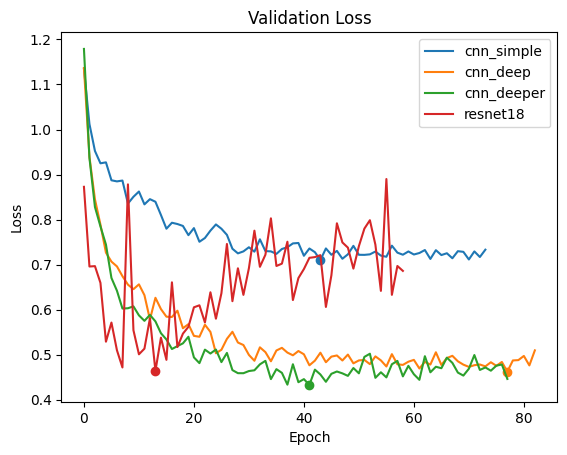

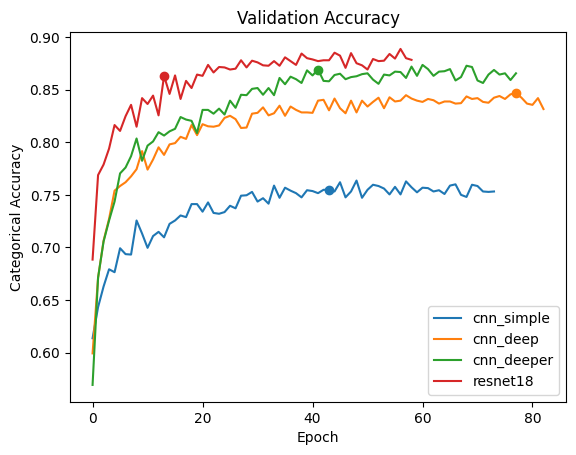

In [6]:
# Plot the validation performances (loss and accuracy)
fig = plt.figure()
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
for history, name, best_iter in zip(histories, names, best_iters):
    plt.plot(history.history["val_loss"], label=name)
    plt.scatter([best_iter], [history.history["val_loss"][best_iter]])
plt.legend()
if SAVE_VIS:
    plt.savefig(os.path.join(VIS_DIR, "validation_loss.png"), bbox_inches="tight")
plt.show()
plt.close()

fig = plt.figure()
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")
for history, name, best_iter in zip(histories, names, best_iters):
    val_acc = history.history["val_sparse_categorical_accuracy"]
    plt.plot(val_acc, label=name)
    plt.scatter(
        [best_iter],
        [val_acc[best_iter]]
    )
plt.legend()
if SAVE_VIS:
    plt.savefig(os.path.join(VIS_DIR, "validation_acc.png"), bbox_inches="tight")
plt.show()
plt.close()

#### Evaluate performance on the test data
There are several ways to view the performance and make comparisons between models. The trade-offs in these comparisons will be application specific. A discussion using each of the metrics is given below.

#### Confusion Matrix
This will let us view what kinds of mistakes, and the proportion of those mistakes the model is making. In benchmark/toy datasets all misclassifications are equal, but in the real-world different mistakes have different implications. Using CIFAR types as a surrogate for the real-world, perhaps misclassifying between types of vehicles (automobile, airplane, ship, and truck) has a low cost, and misclassifying within the animals (bird, cat, deer, dog, frog, horse) also has a low cost, but misclassifying a vehicle as an animal or vice versa has a high cost.

If we can assign each of the 90 modes of misclassifications a weight (in dollars is often particularly useful for stakeholders), then we can calculate the total "cost" of the mistakes of the model.

In this example, we can see most of the misclassifications fall into the "low cost" category of confusing vehicle-with-vehicle or animal-with-animal. There were a few misclassifications like bird-with-airplane, but maybe that is relatively low cost since they are both "aerials". These are the kinds of questions to bring back to stakeholders to evaluate if we need more data and a larger model, or if the performance is acceptable for the current (or first) release and we can plan to improve later.

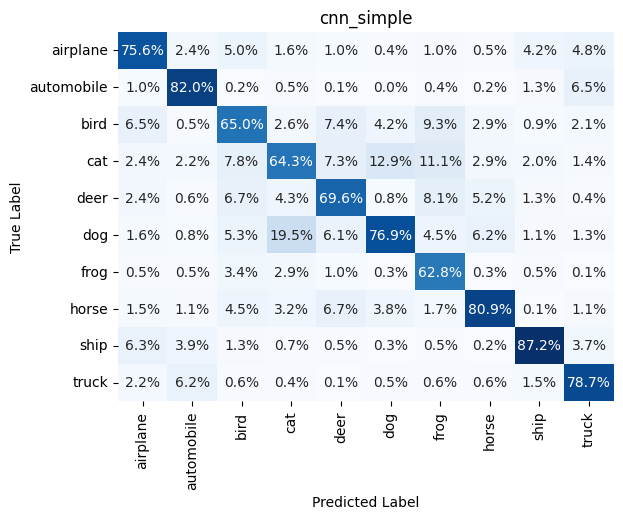

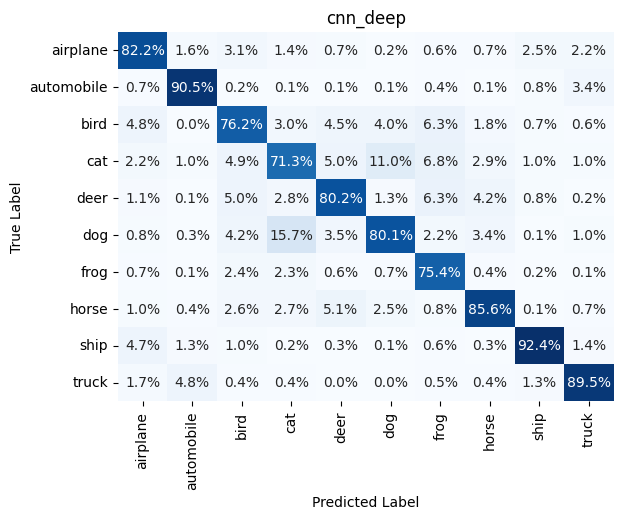

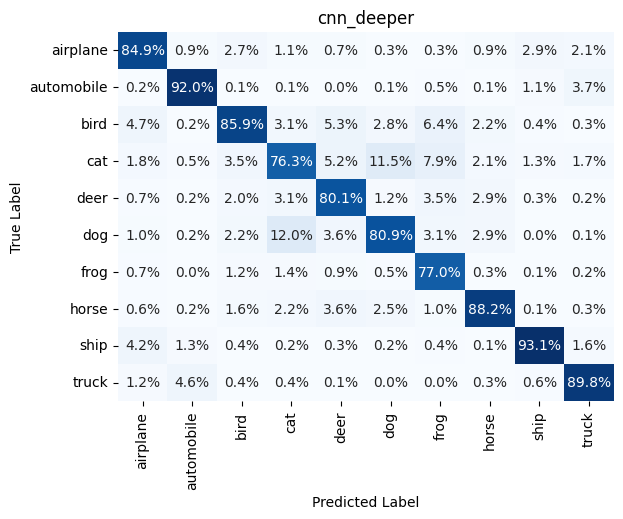

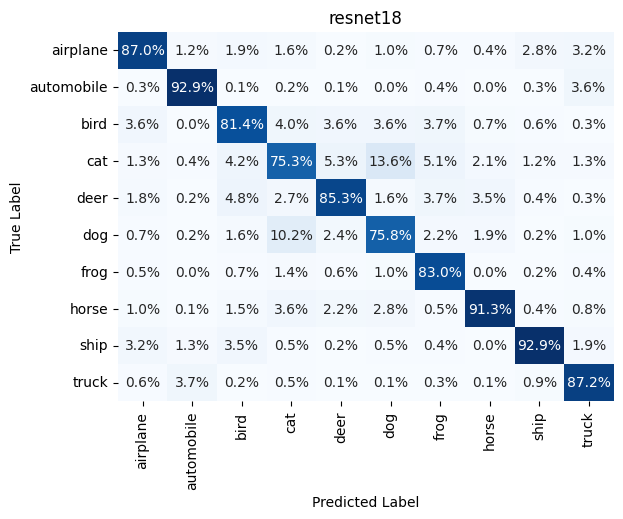

In [ ]:
# Evaluate the performance of each model and compare
performances = []
for model, name in zip(models, names):
    # Load the weights for this model with the best accuracy
    model.load_weights(
        os.path.join(
            CP_DIR,
            name + ".h5"
        )
    )

    # Prime the GPU, otherwise the time is unreliable
    test_preds = model.predict(test_images, batch_size=64, verbose=0)
    
    # Get predictions and measure performance time
    # Take the average over 5 iterations - this exercise assumes we care to some degree about the trade-off between
    #   inference time and accuracy. For a short demo we can just brute force a relatively accurate of inference time
    start_time = time.time()
    for i in range(5):
        test_preds = model.predict(test_images, batch_size=64, verbose=0)
    elapsed_time = time.time() - start_time
    elapsed_time /= 5

    # Get time per batch
    elapsed_time_per_batch = elapsed_time / np.ceil(len(test_images)/64)
    
    # Create a confusion matrix for this model
    test_preds_argmax = np.argmax(test_preds, axis=1)
    cm = metrics.confusion_matrix(
        test_labels, test_preds_argmax, normalize="pred"
    )
    plt.figure("CM")
    plt.title(name)
    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        fmt=".1%",
        xticklabels=classes,
        yticklabels=classes,
        cbar=False
    )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    if SAVE_VIS:
        plt.savefig(
            os.path.join(VIS_DIR, name + "_cm.png"),
            bbox_inches="tight"
        )
    plt.show()
    plt.close()

    # Get the accuracy by category
    avg_accuracy=np.mean(np.diagonal(cm))
    
    # Get the test loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    loss = loss(test_labels, test_preds).numpy()
    
    # Get Averaged One-vs-Rest ROC (micro-averaged, but since the dataset
    #   is perfectly balanced there's no difference between micro- and
    #   macro-averaged)
    test_labels_onehot = tf.keras.utils.to_categorical(test_labels)
    fpr_avg, tpr_avg, _ = roc_curve(test_labels_onehot.ravel(), test_preds.ravel())

    # Package up all the performance data to be plotted outside the loop
    performances.append({
        "avg_accuracy": avg_accuracy,
        "loss": loss,
        "elapsed_time_per_batch": elapsed_time_per_batch,
        "fpr": fpr_avg,
        "tpr":tpr_avg
    })
    
    # Wait 5 seconds between iterations to give the GPU time to cool down
    time.sleep(5)

#### Receiver Operating Characteristic (ROC)

ROC is useful to evaluate the trade-off between false positives and true positives.

As an simple example, lets say we get a stream of images and 1-in-1000 images contain an automobile. It is important to some downstream process to flag images that contain an automobile (and otherwise ignore the image). Unfortunately, it is usually impossible to do a task like this perfectly within the constraints of budget, schedule, and data availability. However, it is often possible to "concentrate" that stream of 1-in-1000 while allowing a small amount of leakage. For instance, of the images with automobiles, it might be within reason to flag 99-in-100 of them with only 11 false positives. That equates to 90/100 of the images we flag will contain an automobile and only 1-in-100,000 of the images we don't flag will contain an automobile. While that isn't perfect, it is a major improvement, and might be enough to improve the downstream process.

An ROC curve gives the FPR and TPR on one plot, so it can be easy to visualize what points are within the performance envelope. From the automobile example, it may be important to have the images we flag to have a higher concentration of automobiles (perhaps this is a marketing campaign and we only want to pay for ads to users that are likely to buy automobile insurance - and having an automobile in the image means they are very likely to own an automobile). If that is the case, we would choose a point with a lower false positive rate and a lower true positive rate - so while we will miss more of the automobile images, the ones we do flag will be very likely to have an automobile (>90/100). Instead, maybe missing an automobile is very expensive and flagging a non-automobile is very cheap. It may instead be important to miss only 1-in-500,000 automobiles even at the expense of flagging more non-automobiles. That would necessitate a different point on the ROC. An ML engineer can create a model and an ROC curve, but choosing the point on the curve to use can only be determined in a discussion with stakeholders.

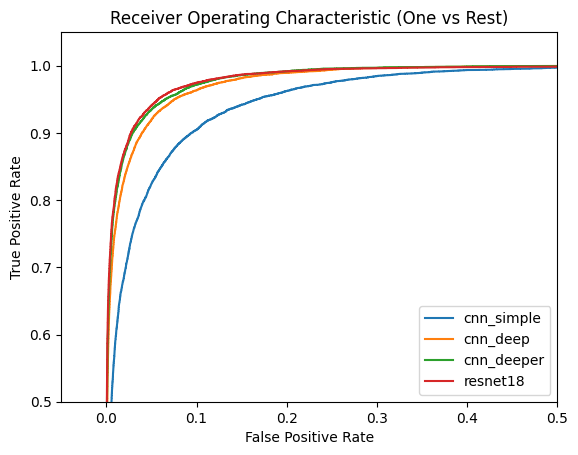

In [8]:
# Compare the Receiver Operating Characteristic Curves between the models
plt.figure("ROCs")
for performance, name in zip(performances, names):
    plt.plot(performance["fpr"], performance["tpr"], label=name)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (One vs Rest)")
plt.legend()
plt.ylim(bottom=0.5)
plt.xlim(right=0.5)
if SAVE_VIS:
    plt.savefig(os.path.join(VIS_DIR, "ROCs.png"), bbox_inches="tight")
plt.show()
plt.close()

#### Performance Table

Better accuracy is usually a trade-off. This toy example is no exception. Often inference time can be a major concern - especially if the process is facing a human (customer or employee). Developing a tool to improve customer experience or employee productivity is only useful if that tool completes the work faster, more accurately, or with less headache. In this example the images are small, so all times are sub-human reaction time. But for larger images or for a significantly larger model (for a significantly more complex task), processing time can become a concern. We can have the same discussion using the toy example as if processing time were an issue.

Of the 4 models, none would be the ideal model for all use cases. We can only pick between the 4 models after being given a set of requirements or goals from our stakeholders.
* The cnn_simple model is "close" to the performance of the other models, but is computationally cheap and fast. If speed is our biggest concern and the difference of 0.23 ms per batch is meaningful, we would want to iterate on models of a similar size to cnn_simple.
* The cnn_deep and cnn_deeper have similar performances both in accuracy and inference time. Choosing between them is is a choice between getting the additional accuracy or getting the reduced inference time - a choice that again requires stakeholders.
* If the desired minimum accuracy was between 74% and 82%, we could create a model of size between cnn_simple and cnn_deep to get the minimum inference time while achieving "good enough" performance.
* The resnet18 model was only marginally better than the cnn_deeper model but significantly slower, which implies that we have reached the limit for the training scheme. I.e. A custom "cnn_deepest" model would like have performance somewhere between cnn_deeper and resnet18. In order to get significantly better performance than the cnn_deeper model, we would need to investigate getting more or better data (which is often hard), better pre-training, or a better training scheme. A better training scheme might be more data augmentation, a better learning rate scheduler (cosine annealing often has better performance than reduceOnPlateau, but also requires more experimentation), more regularization (label smoothing), or a better loss function (loss function should be dependent on the use case).

Choosing between the 4 models is highly dependent on the use case
* If this is a model in production with high volume, the resnet18 might be too slow or use too many cloud computing resources to be economically viable. The trade-off between speed and accuracy for the specific task would determine which of the custom models to use.
* If this was for a data analysis task where the model would be run a handful of times, maybe it is not a big deal to run the model overnight or over a weekend if the additional accuracy is desired. This would also get into the data volume of the task, and the turnaround time that stakeholders desire.
    * My master's thesis with NASA was to develop a machine learning pipeline to flag detects in images of structures where each defect found can equate to hundreds of thousands or millions of dollars saved had that structure failed. It was planned for data to be collected once a year, so taking a weekend or even week/weeks to process all the images was tolerable. For that task, and a 0.5% increase in accuracy would be worth having to deal with long inference times or "costly" computing resources.

<Figure size 640x480 with 0 Axes>

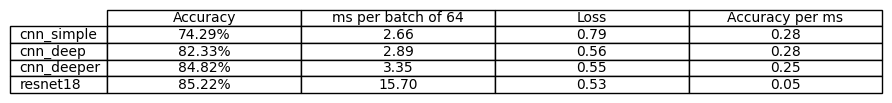

In [11]:
# Create a table of the performance of each method
plt.figure("table")
plt.figure(figsize=(10, 1))
ax = plt.gca()
ax.set_axis_off()
data = []
for perf in performances:
    data.append([
        "{0:.2%}".format(perf["avg_accuracy"]),
        "{0:.2f}".format(perf["elapsed_time_per_batch"] * 1000),
        "{0:.2f}".format(perf["loss"]),
        "{0:.2f}".format(perf["avg_accuracy"] / (perf["elapsed_time_per_batch"] * 1000))
    ])

# Add a table at the bottom of the axes
columns = ('Accuracy', 'ms per batch of 64', 'Loss', 'Accuracy per ms')
ax.table(cellText=data,
          rowLabels=names,
          colLabels=columns,
          loc='center',
          cellLoc='center',
          rasterized=True)
if SAVE_VIS:
    plt.savefig(
        os.path.join(VIS_DIR, 'performance_table.png'),
        bbox_inches='tight',
        dpi=100
    )
plt.show()
plt.close()